<a href="https://colab.research.google.com/github/ptkeens/cs5262-data-science-project/blob/assignment-6/neo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating the Danger of Near Earth Orbit Asteroids

## Background
Asteroids are the rocky remnants of material leftover from the solar system's formation, and are generally found in our solar system's "main belt", located between Mars and Jupitter. <sub>1</sub>. The current known asteroid count is 1,302,459, the vast majority of which orbit in the main asteroid belt. <sub>1</sub>. Asteroids are generally classified into 3 categories: Main Belt, Trojan, and Near-Earth <sub>1</sub>.

## Project Description
This project will focus on Near-Earth Objects (NEO). These objects are defined as "potentially hazardous" when its minimum orbit intersection distance is &lt;0.05 AU (4,647,790 mi) and it has an absolute magnitude of H&lt;22 (i.e. mean diameter > 140 m)<sub>2</sub>. Given that we are evaluating space-bound objects, it is important to remember that many of these values are given in a range format, or are an estimation based on available data sources. The data has been gathered in a kaggle dataset, which was sourced from the NASA NEO Earth Close Approaches API (https://cneos.jpl.nasa.gov/ca/).

## Performance Metrics
In this project, we have a set of 27,423 unique NEO objects with accompanying attribute data such as estimated diameter, relative velocity (to Earth at close approach), the distance by which it misses the Earth, its absolute magnitude, and whether or not it is considered "hazardous".

The goal of this project will be to clean the data to ensure it obeys the defined rules for an object being considered hazardous, and to then use this data as a training set for a machine-learning model to evaluate the boolean condition of if an NEO is considered hazardous. The exact mathematical expressions that will be used will be discovered as we progress through the course.

## Data Sources
This project is using data from a kaggle dataset, found [here](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects). The data was pulled using [this script](https://gist.github.com/sameepv21/79d85bf0ae1830136b292bb9e3eec784)

1 Nasa (2021, July 19). *Asteroids*. https://solarsystem.nasa.gov/asteroids-comets-and-meteors/asteroids/in-depth/

2 Perna, D., Barucci, M.A, Fulchignoni, M (2013). "The near-Earth objects and their potential threat to our planet". *The Astronomy and astrophysics review*, 21(1), 1-28

## Data Dictionary
*   **id** (int): A unique ID given to the object by NASA
*   **name** (string): A unique name given to the object by NASA
*   **est_diameter_min** (float): Estimated minimum diameter of the object in kilometers
*   **est_diameter_max** (float): Estimated maximum diameter of the object in kilometers
*   **relative_velocity** (float): Velocity relative to Earth in Kmph
*   **miss_distance** (float): Distance in kilometers by which the object missed Earth
*   **orbiting_body** (string): The planet this asteroid orbits
*   **sentry_object** (boolean): Whether this object is included in an automated collision monitoring system known as Sentry (True, False)
*   **absolute_magnitude** (float): Intrinsic luminosity of the object. Larger values imply a dimmer object
*   **hazardous** (boolean): Boolean feature stating whether this asteroid is potentailly harmful or not (True, False)

## Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Mount google drive so we can load our data set without uploading
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup a random seed we will use in this notebook
random_seed = 8684

# Load the data
file_path = "/content/drive/MyDrive/Colab Notebooks/neo_v2.csv"
raw = pd.read_csv(file_path)
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


## Examine the properties of the data that has been loaded

In [3]:
# Get some statistical data points from the frame
raw.describe()

id  est_diameter_min  est_diameter_max  relative_velocity  \
count  9.083600e+04      90836.000000      90836.000000       90836.000000   
mean   1.438288e+07          0.127432          0.284947       48066.918918   
std    2.087202e+07          0.298511          0.667491       25293.296961   
min    2.000433e+06          0.000609          0.001362         203.346433   
25%    3.448110e+06          0.019256          0.043057       28619.020645   
50%    3.748362e+06          0.048368          0.108153       44190.117890   
75%    3.884023e+06          0.143402          0.320656       62923.604633   
max    5.427591e+07         37.892650         84.730541      236990.128088   

       miss_distance  absolute_magnitude  
count   9.083600e+04        90836.000000  
mean    3.706655e+07           23.527103  
std     2.235204e+07            2.894086  
min     6.745533e+03            9.230000  
25%     1.721082e+07           21.340000  
50%     3.784658e+07           23.700000  
75%     5.654900e+07           25.700000  
max     7.479865e+07           33.200000

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


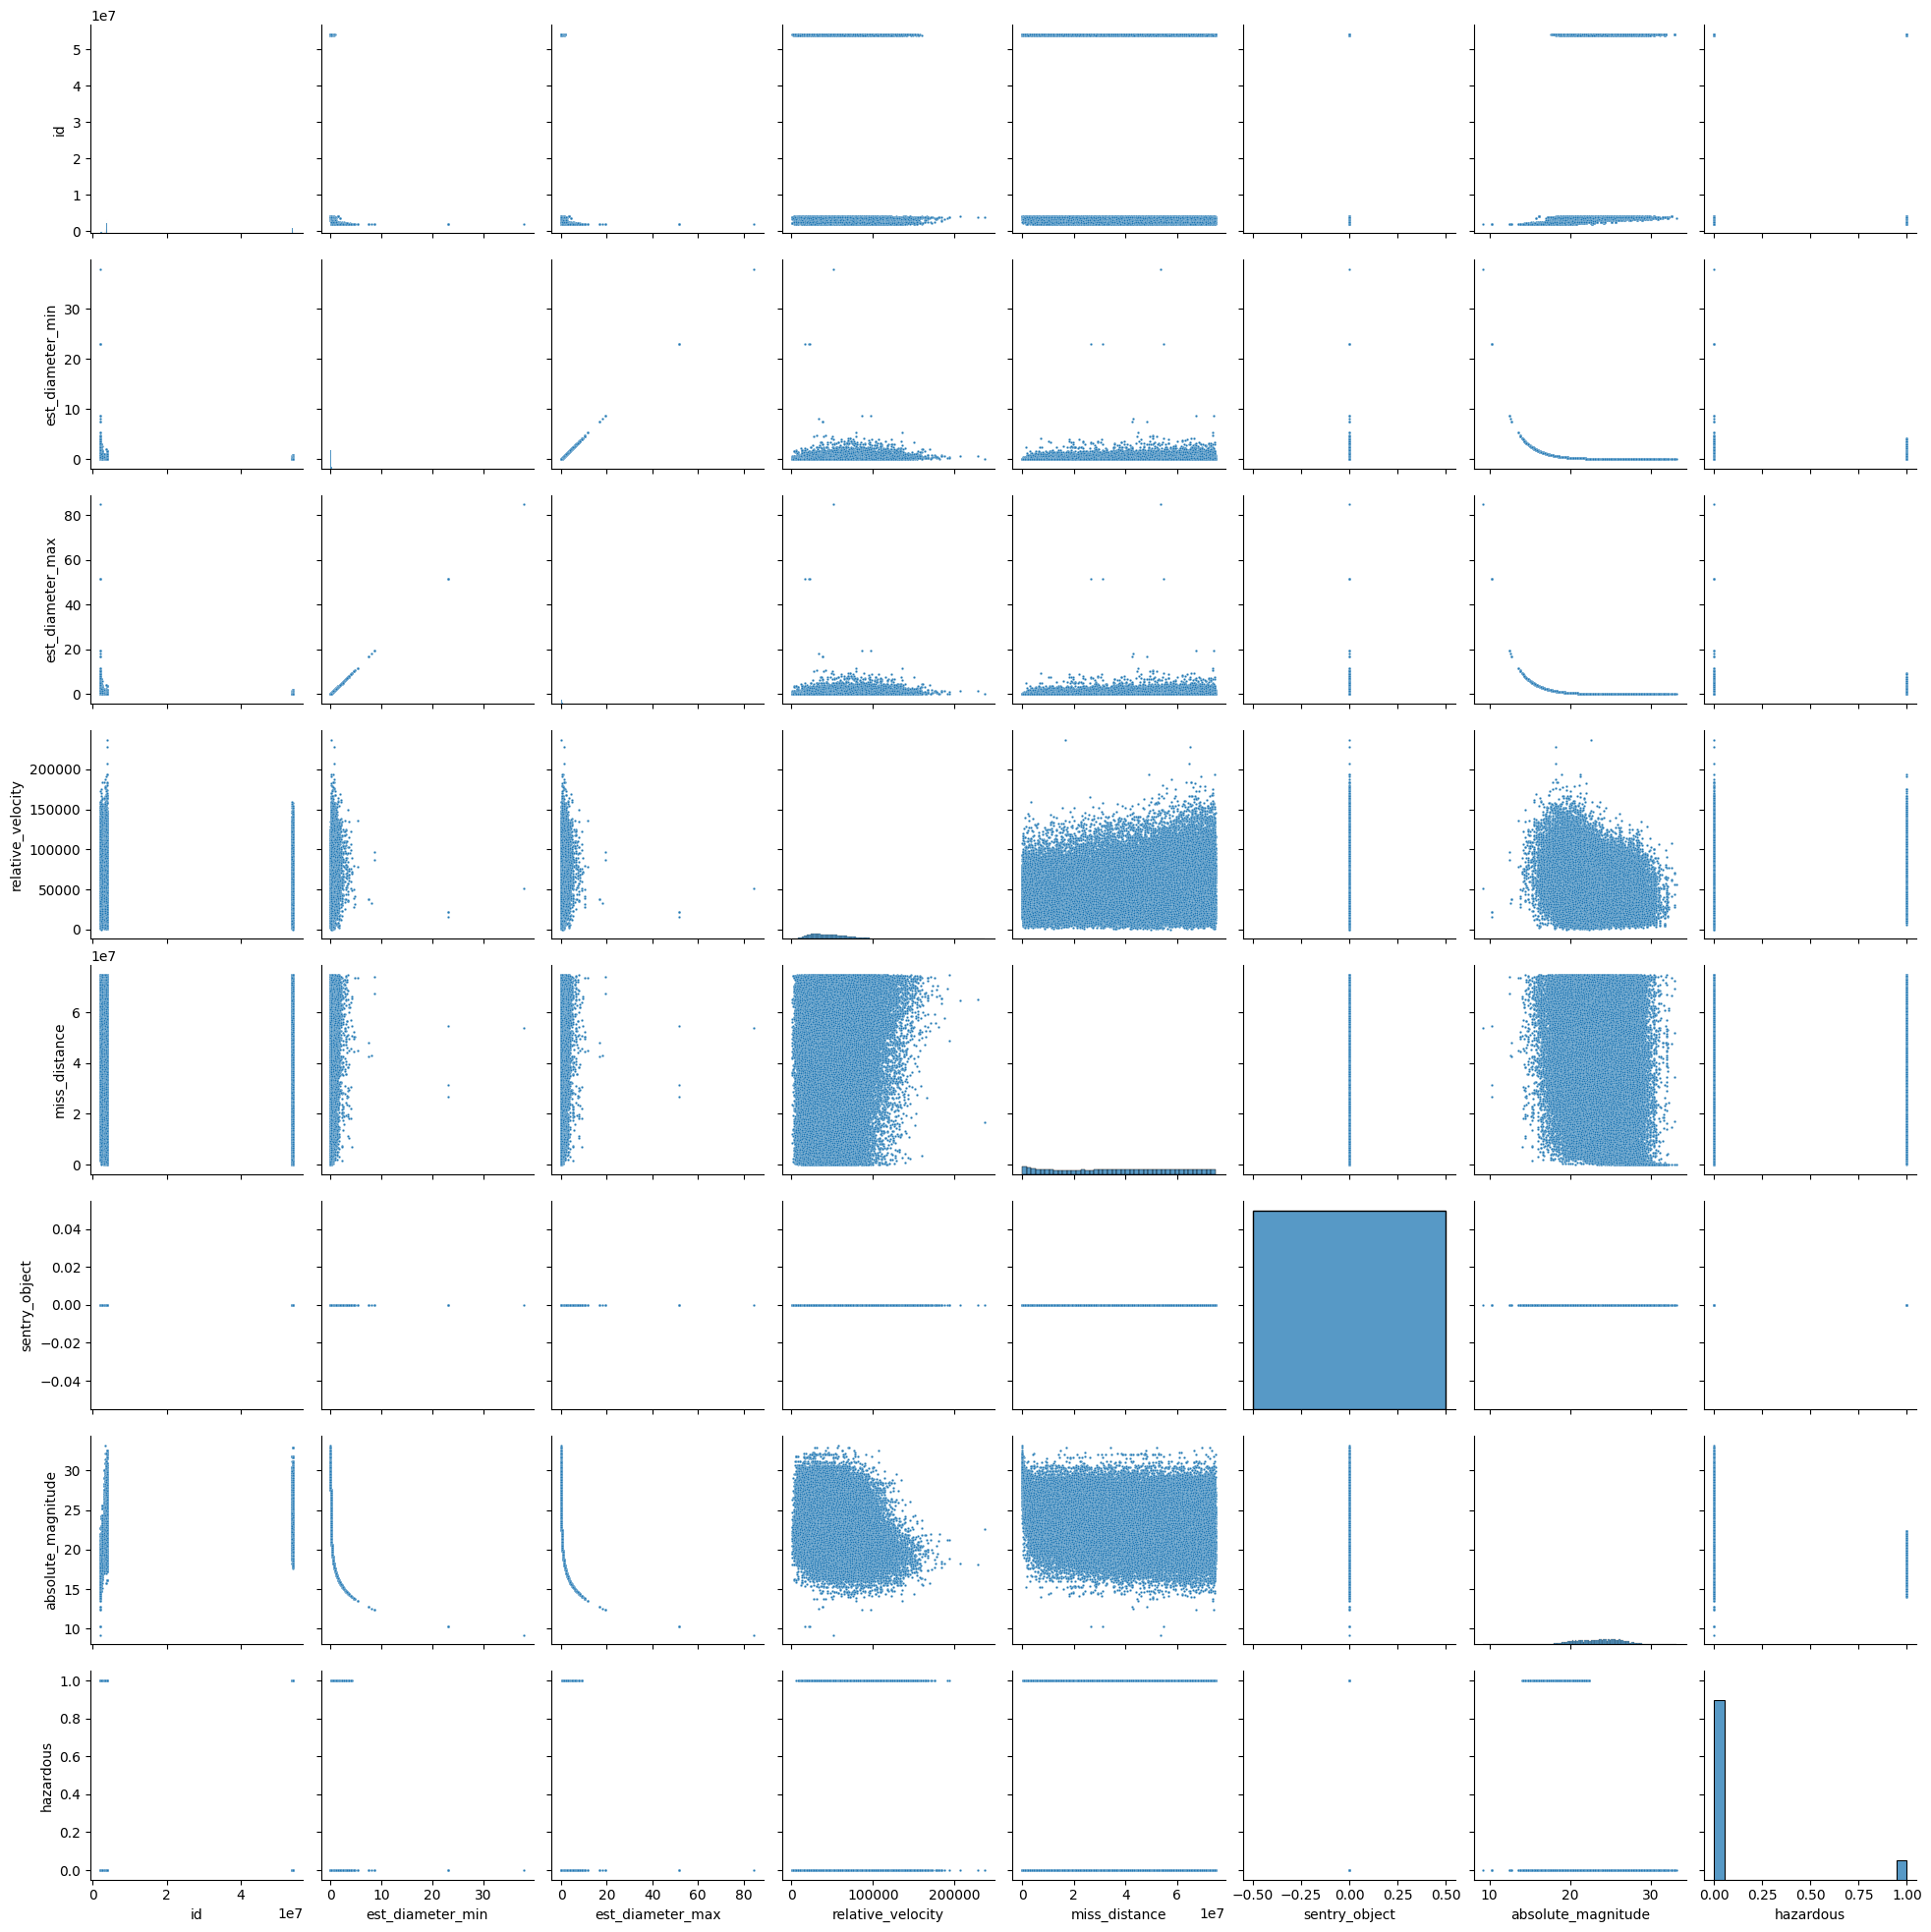

In [4]:
# Construct a pairplot for more detailed correlative analysis
sns.pairplot(raw, plot_kws={'s': 3})

## Exploratory Data Analysis

I have a few primary questions I would like to answer by examining the data more closely:

1.   **How balanced is this data set?** Considering this contains 90,836 NEO events, I imagine that a large percentage of the events are in fact, non-hazardous based on the algorithm described in the project description above. If this is the case, how will we solve this so that our ML model doesn't just predict events as non-hazardous so it performs well?
2.   **What is the correlation between size and magnitude?** We can observe what looks to be a relationship between these values by looking at the pairplot above. What is the nature of this relationship?
3.   **Do we have any data that needs to be dropped?** Can any data that is in the set contribute to leakage? What about outliers?


### 1. Data Set Balance
Lets examine how balanced this dataset is and come to some conclusions

#### Data Exploration

False    81996
True      8840
Name: hazardous, dtype: int64


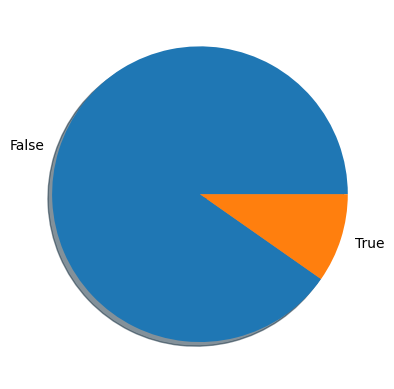

In [5]:
# 1. Data Set Balance
hazardous_values = raw['hazardous'].value_counts()
print(hazardous_values)
plt.pie(hazardous_values, labels=hazardous_values.index, shadow = True)

# Set a max class size to the size of the smaller class
maximum_class_size = hazardous_values[True]


#### Analysis
There are `81,996` instances that have been categorized as non-hazardous, and only `8,840` events that are considered hazardous. This means that only **9%** of our data represents our target fetaure that we want to predict. Given what we know about ML models, the "safe bet" for the model is just to predict non-hazardous regardless of what the data says, because that would be the correct prediction 81% of the time for this data.

#### Tasks
1. I will need to undersample the majority class (non-hazardous) so that I can have a more representative class balance. Ideally I would want to have a near equal split. Considering I have 8,840 hazardous events, I could leverage `scikit-learn` to [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) the data into a majority and minority class set with a maximum class size of 8,840 for each. This will remove the heavy bias and remove the "easy out" for the model.
2. After rebalancing the data set, I need to re-evaluate the data via a new session of EDA to see if/how relationships have changed

### 2. Correlation: Size and Magnitude
Let's examine the correlation between size and magnitude a little closer and come up with an explanation for why we see this.

#### Data Exploration

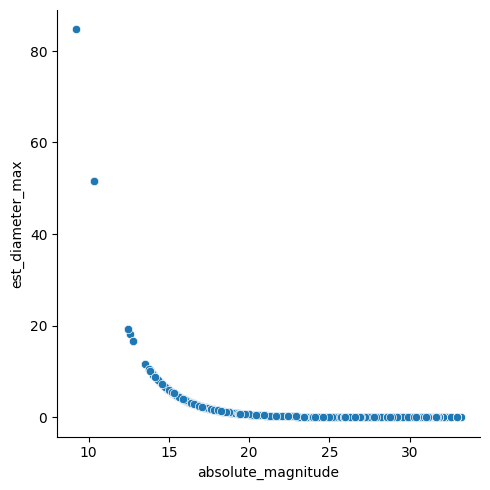

In [6]:
# Plot the relationship between absolute magnitude (x) and the estimated maximum diameter (y)
sns.relplot(raw, x="absolute_magnitude", y="est_diameter_max")

In [7]:
# Create a correlation coefficient between the two features we are interested in
coefficient = pd.DataFrame({
    "diameter": raw["est_diameter_max"],
    "magnitude": raw["absolute_magnitude"],
}).corr()

# Print this out
print(coefficient)

           diameter  magnitude
diameter   1.000000  -0.560188
magnitude -0.560188   1.000000


#### Analysis
So as absolute magnitude increases, I am seeing a decrease in the maximum diameter (estimated). I can observe the same relationship with the minimum estimated diameter, so I chose to do this correlative analysis on the maximum version of the tuple.

The pearson correlation is `-0.56`, which is around the commonly accepted bounds of `0.5` to `1.0`, indicating a strong correlation indicating that as one feature increases, the other decreases.

So the features are correlated, but why? The estimated diameter is rather self-evident, but what does absolute magnitude represent? We know that absolute magnitude represents the intrinsic [luminosity](https://www.phys.ksu.edu/personal/wysin/astro/magnitudes.html) of an object (how bright it is from a distance of 10 parsecs from the earth). We also know, due to the inverse square law for light, that the intensity of light diminishes proportionally to the square of the distance between the source and the observer. The absolute magnitude scale indeed reflects this relationship but in the inverse direction: Larger magnitude values represent fainter objects.

Taking this into consideration, this relationship **makes sense**, and would be expected. This also explains why the determination for an object being hazardous relies of the H < 22. When I first saw this formula, I was very confused about why we would want a *smaller* value!


#### Tasks
I do not feel that there are any tasks to be done for this observation, but in keeping with the format of this notebook, I have a task section for this data observation.

### 3. Data Pruning


#### Data Exploration

Sentry object values: 
False    90836
Name: sentry_object, dtype: int64

Unique ID values: 
27423

List of orbiting bodies
Earth    90836
Name: orbiting_body, dtype: int64


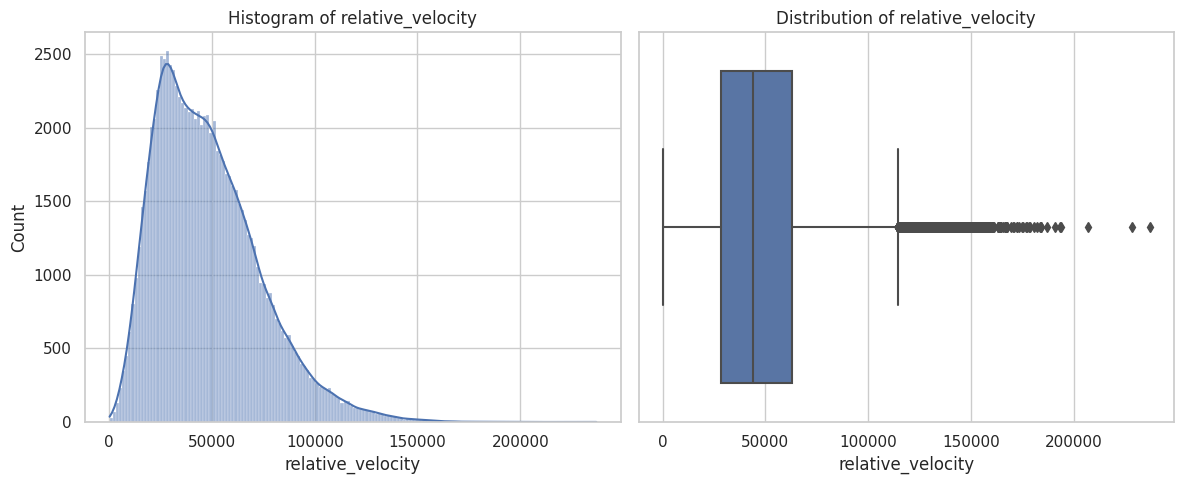

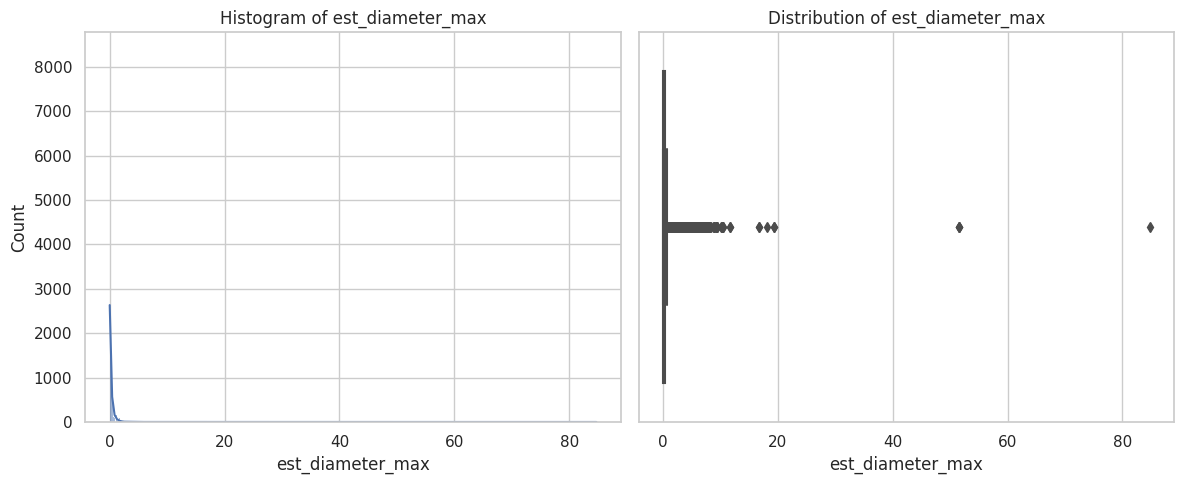

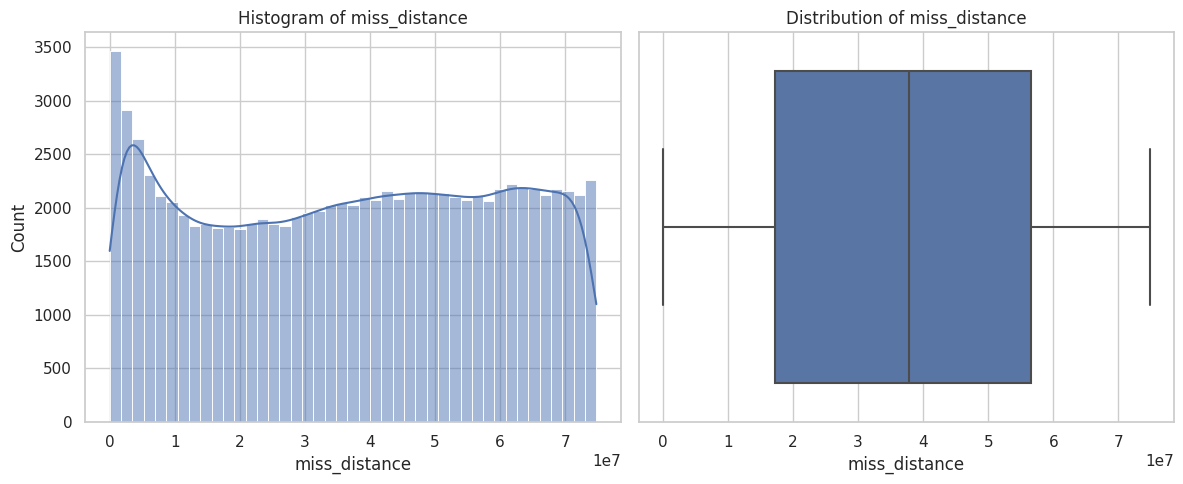

In [8]:
# Create a function to produce our visualizations so we don't repeat this code
def create_distribution_plot(data, column_name):
    # Set the style for the plot (optional)
    sns.set(style="whitegrid")

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot a histogram on the left subplot
    sns.histplot(data=data, x=column_name, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {column_name}')

    # Plot a distribution (box plot) on the right subplot
    sns.boxplot(data=data, x=column_name)
    axes[1].set_title(f'Distribution of {column_name}')

    # Adjust plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# What is the distribution of values for sentry_object
sentry_object_values = raw['sentry_object'].value_counts()
print("Sentry object values: ")
print(sentry_object_values)
print()

# How many unique nasa IDs do we have?
unique_ids = raw['id'].value_counts()
print("Unique ID values: ")
print(len(unique_ids))
print()

# How many orbiting bodies do we have?
orbiting_bodies = raw['orbiting_body'].value_counts()
print("List of orbiting bodies")
print(orbiting_bodies)

# Distribution of values for relative_velocity
create_distribution_plot(raw, 'relative_velocity')

# Distribution of values for est_diameter_max
create_distribution_plot(raw, 'est_diameter_max')

# Distribution of values for `miss_distance`
create_distribution_plot(raw, 'miss_distance')

#### Analysis
All instances contain the same values for `orbiting_body` and `sentry_object`. Keeping these features only adds to processing overhead and bloats the data set.

We have 27,423 unique NASA IDs in the data set. A NASA ID is **not** something that would be available "in the field", and would represent data leakage. The same could be said for the name of the object.

We have 2 values representing diameter: `est_diameter_max` and `est_diameter_min`. We don't need two values for this.

In our distribution graph for `relative_velocity` and `est_diameter_max`, we can see a *number* of outliers beyond the 75% IQR mark. We should consider pruning these from the data set to ensure an even distribution of data.

The distribution for `miss_distance` is quite even, and has no obvious outliers beyond IQR boundaries based on the box chart.



#### Tasks
1. I should consider doing some data cleaning and feature engineering. I will end up dropping `id`, `name`, `sentry_object`, and `orbiting_body` from the data set. These do not provide any relevant information and can run the risk of overfitting, and/or can be representative of data leakage.

2. I should also create a new feature, `est_diameter_avg`, which averages the min and max estimated diameter for each instance in the data set. I also think that `est_diameter_min` and `est_diameter_max` should be dropped from the data set after the new feature is engineered.

3. We have some significant outliers on `relative_velocity` and `est_diameter_max` that we should consider pruning from the data set, so as to have a more even distribution of values for the model to consider.

4. I should re-engineer the `hazardous` column to contain an integer representation of whether or not an object is considered hazardous. Having this be an integer (0,1) will assist in performing analysis.

5. After doing the above, an additional round of EDA should be conducted, as well as an exploration of class balance, to ensure that the data is still in an ideal condition to fit to the model.

## Data Cleaning
I will now perform the tasks related to data cleaning outlined above

### Prune The Data
I identified a number of features that will not contribute to our model. I will begin by removing them from the dataset.

In [9]:
# Create a copy of our data set with some features dropped.
pruned = raw.drop(['id','name','orbiting_body','sentry_object'], axis=1)
pruned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float64
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 3.6 MB


### Rebalance The Data
As discovered earlier, the dataset is heavily skewed towards non-hazardous events. In order for the model to perform, the majority and minority class should be much closer to balanced equally. I will accomplish this by undersampling the majority class (non-hazardous).

False    8840
True     8840
Name: hazardous, dtype: int64


([<matplotlib.patches.Wedge at 0x7e72b9d1e9e0>,
 [Text(6.735557395310444e-17, 1.1, 'False'),
  Text(-2.0206672185931328e-16, -1.1, 'True')])

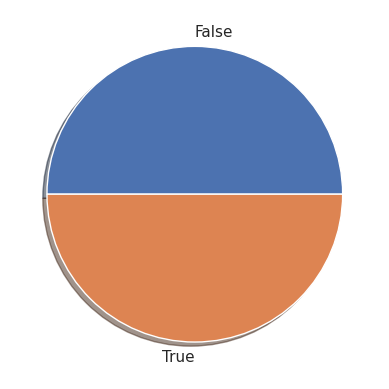

In [10]:
# Define our majority and minority class by selecting hazardous into one frame, and non-hazardous into another
raw_majority = pruned[pruned['hazardous'] == False]
raw_minority = pruned[pruned['hazardous'] == True]

# Resample the classes with the size of the minority class as the max
majority_class = resample(raw_majority, replace=False, n_samples=maximum_class_size, random_state=random_seed)
minority_class = resample(raw_minority, replace=True, n_samples=maximum_class_size, random_state=random_seed)

# Combine them into a new data frame
balanced = pd.concat([majority_class, minority_class])

# Examine the split of our new data frame
balanced_hazardous_values = balanced['hazardous'].value_counts()
print(balanced_hazardous_values)
plt.pie(balanced_hazardous_values, labels=balanced_hazardous_values.index, shadow = True)

### Feature Engineering: est_diameter_avg
As discussed above, create a new feature called `est_diameter_avg` that contains the average of `est_diameter_min` and `est_diameter_max`, and then drop the source features.

In [11]:
# Copy our frame to alter it
balanced_copy = balanced.copy()

# Create a new feature to represnt the average
balanced_copy['est_diameter_avg'] = (balanced_copy['est_diameter_min'] + balanced_copy['est_diameter_max']) / 2

# Drop the old 2 columns
balanced2 = balanced_copy.drop(['est_diameter_min', 'est_diameter_max'], axis=1)

# Describe the new data frame
balanced2.describe()

relative_velocity  miss_distance  absolute_magnitude  est_diameter_avg
count       17680.000000   1.768000e+04        17680.000000      17680.000000
mean        54977.501841   3.857827e+07           22.100145          0.330351
std         27128.551508   2.184006e+07            2.839546          0.553408
min          1111.639793   1.310432e+04           10.310000          0.001105
25%         34355.778343   1.940617e+07           20.210000          0.062165
50%         51277.004694   3.972997e+07           21.500000          0.215547
75%         70615.322882   5.777741e+07           24.200000          0.390429
max        176609.502298   7.478231e+07           32.950000         37.285727

### Outlier Removal
As discussed above, there are some extreme outliers to clean up

##### Relative Velocity

Interquartile Range for relative_velocity: 36259.54453896034
Upper bound for relative_velocity: 121378.68523657019
Total rows identified as outliers for relative_velocity: 379


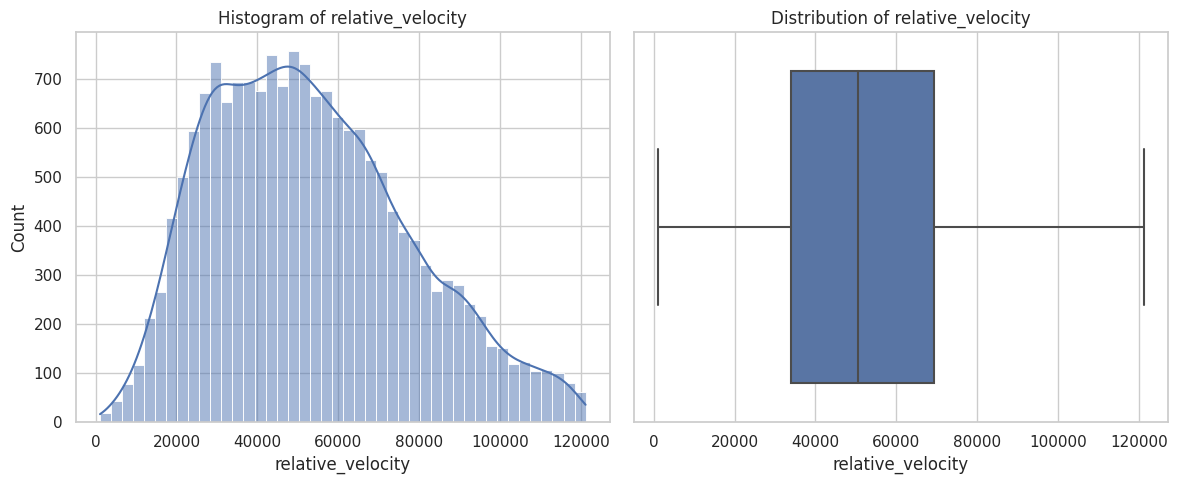

In [12]:
# Create a function we can re-use to prune outliers
def remove_outliers(data, column, iqr_fold=1.5):
  # create a copy of the data frame on which to apply the mask
  data_copy = data.copy()

  # Get the IQR
  iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
  print(f"Interquartile Range for {column}: {iqr}")

  # Determine our upper bound
  upper_bound = data[column].quantile(0.75) + (iqr * iqr_fold)
  print(f"Upper bound for {column}: {upper_bound}")

  # Create a mask to reduce our data set
  outlier_mask = data[column] > upper_bound
  outlier_count = outlier_mask.sum()
  print(f"Total rows identified as outliers for {column}: {outlier_count}")

  # Return the reduced data in a new data frame
  return data_copy[~outlier_mask]

# Remove any rows whose relative_velocity is > 1.5x IQR
relative_velocity_pruned_data = remove_outliers(balanced2, 'relative_velocity', 1.4)
create_distribution_plot(relative_velocity_pruned_data, 'relative_velocity')

##### Estimated Average Diameter

Interquartile Range for est_diameter_avg: 0.31587970795
Upper bound for est_diameter_avg: 0.8518637944749999
Total rows identified as outliers for est_diameter_avg: 1192


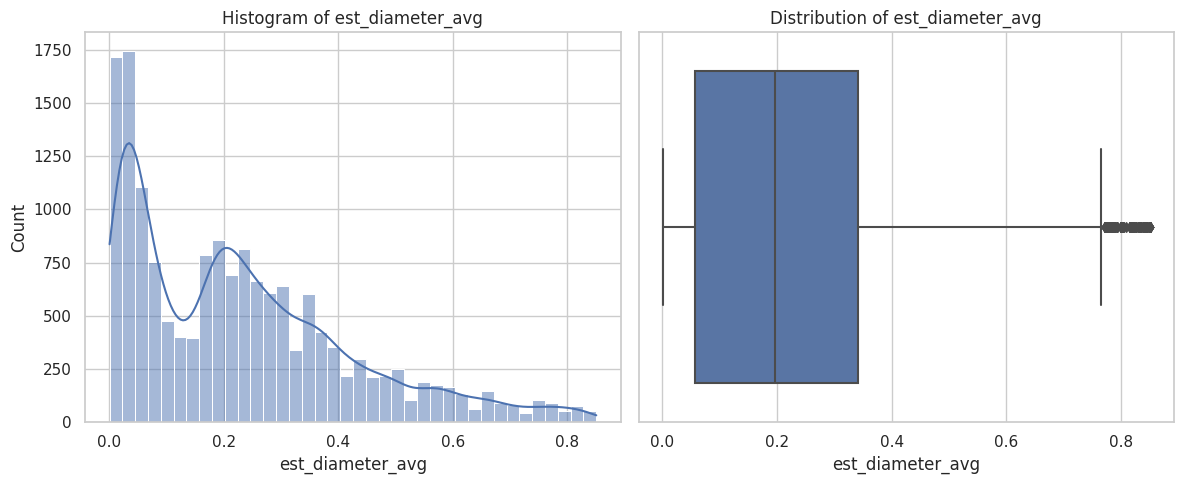

In [13]:
# Remove any rows whose est_diameter_avg is > 1.5x IQR
balanced_and_pruned = remove_outliers(relative_velocity_pruned_data, 'est_diameter_avg', 1.5)
create_distribution_plot(balanced_and_pruned, 'est_diameter_avg')

## Post-Cleaning EDA
Now that cleaning, pruning, and feature engineering is complete, examine the data again to make sure we retained our balance, and to look for any other oddities in the data that may need cleaning/addressing.

Total row count in final data set: 16109
False    8485
True     7624
Name: hazardous, dtype: int64


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


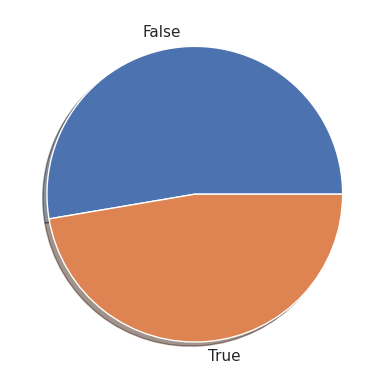

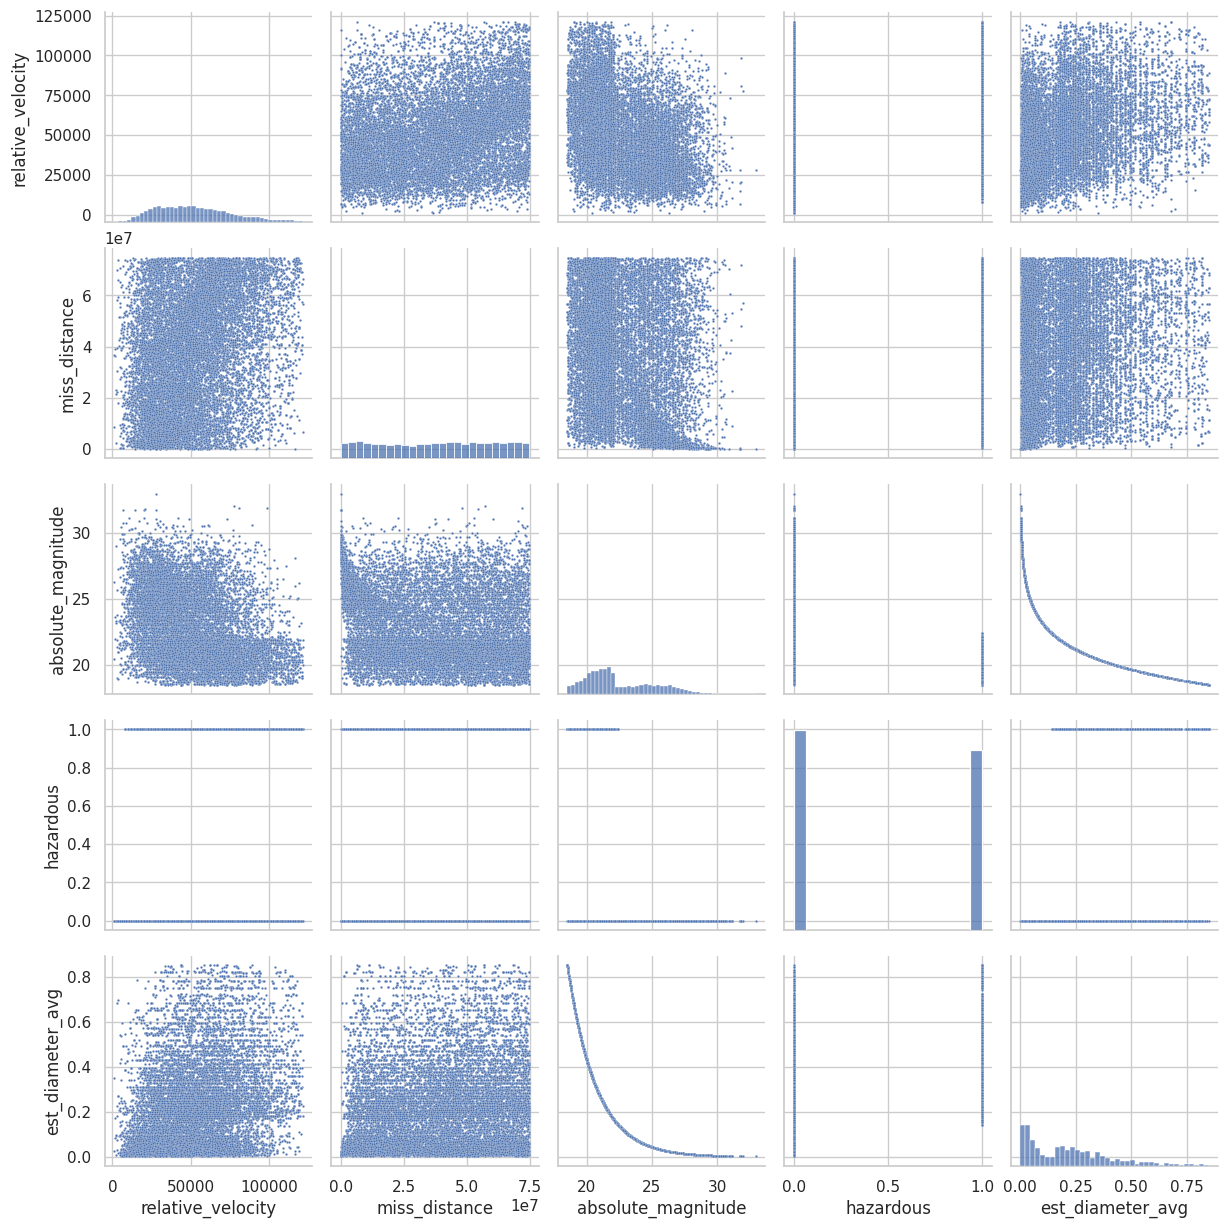

In [14]:
# Get the count of rows
balanced_and_pruned_rows = len(balanced_and_pruned)
print(f"Total row count in final data set: {balanced_and_pruned_rows}")

# examine our hazardous split
balanced_hazardous_count = balanced_and_pruned['hazardous'].value_counts()
print(balanced_hazardous_count)
plt.pie(balanced_hazardous_count, labels=balanced_hazardous_count.index, shadow = True)

# Construct a pairplot for more detailed correlative analysis
sns.pairplot(balanced_and_pruned, plot_kws={'s': 3})

From the chart above, I can see that there are no obvious correlations in the data beyond the one that is already identified, which is the relationship between absolute magnitude and the diameter.

The breakdown in classes is within a good margin (53%/47%), with a slight advantage to the majority class of non-hazardous.

## Feature Engineering

The final data set after pruning and feature engineering is as follows:


*   `relative_velocity` (float): The relative velocity, in Kmph, of the object compared to Earth.
*   `miss_distance` (float): Distance in kilometers by which the object missed Earth
*   `absolute_magnitude` (float): Intrinsic luminosity of the object. Larger values imply a dimmer object
*   `hazardous` (bool): Boolean feature stating whether this asteroid is potentailly harmful or not (True, False)
*   `est_diameter_avg` (float): The estimated average diameter of the object (derived from the min and max values recorded)





## Train Test Split
The final data set has `16,131` instances available, and this is how they will be broken down:

Based on these numbers:
*   12,098 records (~**75%**) will go to *training* the model
*   4,033 records (~**25%**) will go to *testing* the model

All of these records should be selected randomly so as to avoid any bias based on where in the data set the instance occurred. The final numbers will be different based on the final set, but the percentages will be static.


In [15]:
class_column = ['hazardous']

# Split our data
X_train, X_test, y_train, y_test = train_test_split(balanced_and_pruned.drop(columns=class_column), balanced_and_pruned[class_column], test_size=.25, random_state=random_seed)

# Print out the "shape" of our x data
print(f"X train dimensions: {X_train.shape}")
print(f"X test dimensions: {X_test.shape}")
print()
print(f"y train dimensions: {y_train.shape}")
print(f"y test dimensions: {y_test.shape}")

# code-level assertions to fail if our counts are not what we expect
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

X train dimensions: (12081, 4)
X test dimensions: (4028, 4)

y train dimensions: (12081, 1)
y test dimensions: (4028, 1)


## ML Pipeline: Logistic Regression



In [16]:
# Setup the pipelines (we do not need imputation steps, and we only have numeric data)
num_pipeline = Pipeline(steps=[('scale_num', StandardScaler())])

# All of our numeric columns
num_cols = ['relative_velocity', 'miss_distance', 'absolute_magnitude', 'est_diameter_avg']

# Setup our preprocessing
preproc = ColumnTransformer([('num_pipe', num_pipeline, num_cols)],
                             remainder='passthrough')

# Setup the actual pipeline
pipe = Pipeline(steps=[('preproc', preproc), ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01, random_state=random_seed))])

# Visualize the pipeline
with config_context(display='diagram'):
  display(pipe)


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('scale_num',
                                                                   StandardScaler())]),
                                                  ['relative_velocity',
                                                   'miss_distance',
                                                   'absolute_magnitude',
                                                   'est_diameter_avg'])])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', random_state=8684,
                                    solver='saga', tol=0.01))])

### Model Fitting and Evaluation
I believe that the most important features for predicting will be the `miss_distance` and `absolute_magnitude`, given that these should be predictors for whether or not something is hazardous.

I anticipate that the model will recognize the patterns underlying the classification and adapt accordingly. I don't really have the experience to predict a certain % of success, but I do expect it to perform well.

I plan on evaluating the efficacy of the model by using a confusion matrix so we can see the precision and accuracy of the model's output. I can also evaluate the arithmatic and arithmetic means so we can explore the results from many perspectives.

In [17]:
# cross validation hyper parameter tuning (values taken from lecture)
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }

# Cross validate with a grid search
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True, n_jobs=-1)

# Display our tuning grid
print(tuning_grid)

# Perform our model fit
grid_search.fit(X_train, y_train.values.ravel())

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]), 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         ['relative_velocity',
                                                                          'miss_distance',
                                                                          'absolute_magnitude',
                                                                          'est_diameter_avg'])])),
                                       ('mdl',
                                        LogisticRegression(penalty='elasticnet',
                                                           random_state=8684,
                                                           solver='saga',
                                                           tol=0.01))]),
             n_jobs=-1,
             param_grid={'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
                         'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             return_train_score=True)

In [18]:
print(grid_search.best_score_)
grid_search.best_params_

0.8721967328552992


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}

In [19]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_mdl__C  \
0        0.029405      0.006800         0.009197        0.002964          0.1   
1        0.047297      0.016090         0.007362        0.003277          0.1   
2        0.059549      0.016911         0.012137        0.005243          0.1   
3        0.065241      0.012060         0.012715        0.004845          0.1   
4        0.050477      0.007214         0.012760        0.004739          0.1   
5        0.049585      0.004142         0.012126        0.004230   316.227766   
6        0.059958      0.011557         0.008996        0.004664   316.227766   
7        0.049822      0.005004         0.009981        0.005652   316.227766   
8        0.050364      0.006123         0.011599        0.006353   316.227766   
9        0.051091      0.005601         0.016455        0.006273   316.227766   
10       0.048646      0.013812         0.014110        0.002267    1000000.0   
11       0.102771      0.017769         0.022370        0.010430    1000000.0   
12       0.083390      0.038172         0.014943        0.007571    1000000.0   
13       0.039639      0.012376         0.007976        0.003197    1000000.0   
14       0.035773      0.010574         0.010535        0.005039    1000000.0   

   param_mdl__l1_ratio                                             params  \
0                  0.0              {'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}   
1                 0.25             {'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}   
2                  0.5              {'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}   
3                 0.75             {'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}   
4                  1.0              {'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}   
5                  0.0  {'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...   
6                 0.25  {'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...   
7                  0.5  {'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...   
8                 0.75  {'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...   
9                  1.0  {'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...   
10                 0.0        {'mdl__C': 1000000.0, 'mdl__l1_ratio': 0.0}   
11                0.25       {'mdl__C': 1000000.0, 'mdl__l1_ratio': 0.25}   
12                 0.5        {'mdl__C': 1000000.0, 'mdl__l1_ratio': 0.5}   
13                0.75       {'mdl__C': 1000000.0, 'mdl__l1_ratio': 0.75}   
14                 1.0        {'mdl__C': 1000000.0, 'mdl__l1_ratio': 1.0}   

    split0_test_score  split1_test_score  split2_test_score  ...  \
0            0.863467           0.872930           0.869205  ...   
1            0.863881           0.872930           0.868377  ...   
2            0.863881           0.872930           0.867550  ...   
3            0.863467           0.874172           0.866722  ...   
4            0.863881           0.877070           0.862169  ...   
5            0.862226           0.870033           0.861755  ...   
6            0.862226           0.870033           0.861755  ...   
7            0.862226           0.870033           0.861755  ...   
8            0.862226           0.870033           0.861755  ...   
9            0.862226           0.870033           0.861755  ...   
10           0.862226           0.870033           0.861755  ...   
11           0.862226           0.870033           0.861755  ...   
12           0.862226           0.870033           0.861755  ...   
13           0.862226           0.870033           0.861755  ...   
14           0.862226           0.870033           0.861755  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          0.871369        0.008988                5            0.873965   
1          0.871783        0.009003                3            0.874586   
2          0.872197        0.009120                2            0.875000   
3          0.872197        0.009127                1            0.874897   
4    

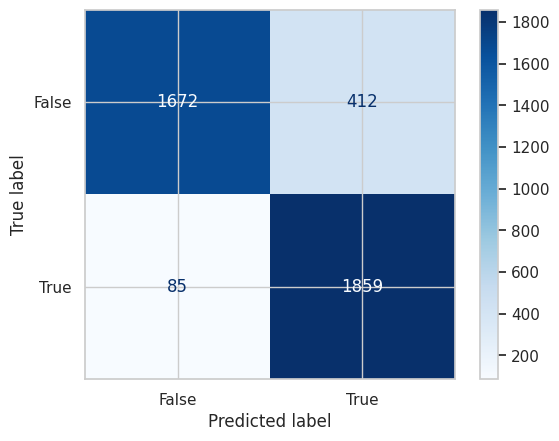

In [20]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))

# Create a ConfusionMatrixDisplay with the custom colormap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)

# Plot the confusion matrix with the custom colormap
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()


In [21]:
lr_train_report = classification_report(y_train, grid_search.best_estimator_.predict(X_train), output_dict=True)
lr_test_report = classification_report(y_test, grid_search.best_estimator_.predict(X_test), output_dict=True)

print("Training performance: ")
print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))

print("Testing performance: ")
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

Training performance: 
              precision    recall  f1-score   support

       False       0.96      0.79      0.87      6401
        True       0.80      0.96      0.88      5680

    accuracy                           0.87     12081
   macro avg       0.88      0.88      0.87     12081
weighted avg       0.89      0.87      0.87     12081

Testing performance: 
              precision    recall  f1-score   support

       False       0.95      0.80      0.87      2084
        True       0.82      0.96      0.88      1944

    accuracy                           0.88      4028
   macro avg       0.89      0.88      0.88      4028
weighted avg       0.89      0.88      0.88      4028



## ML Pipeline: Random Forest Classifier


In [57]:
# Define our random forest classifier pipeline
rf_pipe = Pipeline(steps=[('preproc', preproc), ('rf_mdl', RandomForestClassifier(random_state=random_seed))])

# Setup our hyperparameters & grid search
rf_tuning_grid = {
  'rf_mdl__n_estimators': [100, 150, 200, 250, 300],      # Number of trees in the forest (default=100)
  'rf_mdl__max_depth': [1, 2, 3, 4],                   # Max depth of the tree (default=None)
}

# Perform our grid search
rf_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=rf_tuning_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
rf_grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         ['relative_velocity',
                                                                          'miss_distance',
                                                                          'absolute_magnitude',
                                                                          'est_diameter_avg'])])),
                                       ('rf_mdl',
                                        RandomForestClassifier(random_state=8684))]),
             n_jobs=-1,
             param_grid={'rf_mdl__max_depth': [1, 2, 3, 4],
                         'rf_mdl__n_estimators': [100, 150, 200, 250, 300]},
             scoring='accuracy', verbose=2)

In [58]:
rf_grid_search.best_params_

{'rf_mdl__max_depth': 4, 'rf_mdl__n_estimators': 100}

In [59]:
pd.DataFrame(rf_grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.007033      0.038997         0.087324        0.010738   
1        1.636412      0.084309         0.125398        0.023052   
2        1.263902      0.182622         0.087562        0.007856   
3        1.287820      0.010755         0.094564        0.000610   
4        2.384313      0.462314         0.198974        0.029468   
5        1.338146      0.094692         0.060089        0.020105   
6        1.021988      0.010137         0.065075        0.002282   
7        1.371117      0.018303         0.081947        0.002053   
8        1.682507      0.023683         0.101620        0.001684   
9        2.046976      0.039458         0.155724        0.052964   
10       1.587352      0.247118         0.091242        0.004421   
11       2.052989      0.585010         0.085970        0.024681   
12       2.203776      0.338910         0.085413        0.001410   
13       2.093957      0.018980         0.106002        0.002295   
14       3.377237      0.683579         0.212310        0.053341   
15       1.605517      0.176754         0.066403        0.021750   
16       1.428590      0.028742         0.071534        0.003778   
17       1.916350      0.030133         0.089838        0.001335   
18       2.473309      0.082272         0.120695        0.006831   
19       4.211571      0.715339         0.162871        0.078951   

   param_rf_mdl__max_depth param_rf_mdl__n_estimators  \
0                        1                        100   
1                        1                        150   
2                        1                        200   
3                        1                        250   
4                        1                        300   
5                        2                        100   
6                        2                        150   
7                        2                        200   
8                        2                        250   
9                        2                        300   
10                       3                        100   
11                       3                        150   
12                       3                        200   
13                       3                        250   
14                       3                        300   
15                       4                        100   
16                       4                        150   
17                       4                        200   
18                       4                        250   
19                       4                        300   

                                               params  split0_test_score  \
0   {'rf_mdl__max_depth': 1, 'rf_mdl__n_estimators...           0.876831   
1   {'rf_mdl__max_depth': 1, 'rf_mdl__n_estimators...           0.876831   
2   {'rf_mdl__max_depth': 1, 'rf_mdl__n_estimators...           0.876831   
3   {'rf_mdl__max_depth': 1, 'rf_mdl__n_estimators...           0.876831   
4   {'rf_mdl__max_depth': 1, 'rf_mdl__n_estimators...           0.876831   
5   {'rf_mdl__max_depth': 2, 'rf_mdl__n_estimators...           0.879563   
6   {'rf_mdl__max_depth': 2, 'rf_mdl__n_estimators...           0.879563   
7   {'rf_mdl__max_depth': 2, 'rf_mdl__n_estimators...           0.879563   
8   {'rf_mdl__max_depth': 2, 'rf_mdl__n_estimators...           0.879563   
9   {'rf_mdl__max_depth': 2, 'rf_mdl__n_estimators...           0.879315   
10  {'rf_mdl__max_depth': 3, 'rf_mdl__n_estimators...           0.880060   
11  {'rf_mdl__max_depth': 3, 'rf_mdl__n_estimators...           0.880060   
12  {'rf_mdl__max_depth': 3, 'rf_mdl__n_estimators...           0.880060   
13  {'rf_mdl__max_depth': 3, 'rf_mdl__n_estimators...           0.880060   
14  {'rf_mdl__max_depth': 3, 'rf_mdl__n_estimators...           0.880308   
15  {'rf_mdl__max_depth': 4, 'rf_mdl__n_estimators...           0.880060   
16  {'rf_mdl__max_depth': 4, 'rf_mdl__n_estimators...           0.880060   
17  {'rf_

In [60]:
rf_train_report = classification_report(y_train, rf_grid_search.best_estimator_.predict(X_train), output_dict=True)
rf_test_report = classification_report(y_test, rf_grid_search.best_estimator_.predict(X_test), output_dict=True)

print("Training performance: ")
print(classification_report(y_train, rf_grid_search.best_estimator_.predict(X_train)))

print("Testing performance: ")
print(classification_report(y_test, rf_grid_search.best_estimator_.predict(X_test)))

Training performance: 
              precision    recall  f1-score   support

       False       0.99      0.80      0.88      6401
        True       0.81      0.99      0.89      5680

    accuracy                           0.89     12081
   macro avg       0.90      0.89      0.89     12081
weighted avg       0.91      0.89      0.89     12081

Testing performance: 
              precision    recall  f1-score   support

       False       0.99      0.81      0.89      2084
        True       0.83      0.99      0.90      1944

    accuracy                           0.90      4028
   macro avg       0.91      0.90      0.90      4028
weighted avg       0.91      0.90      0.90      4028



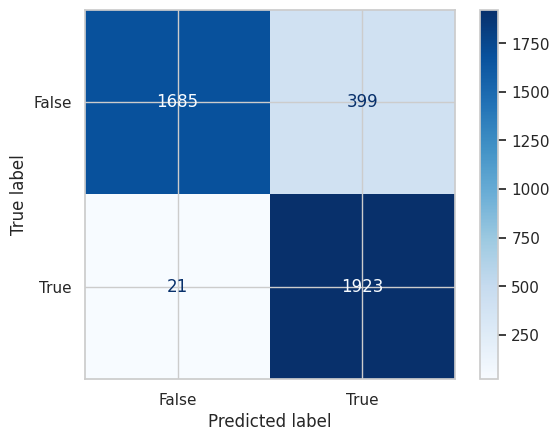

In [61]:
rf_cm = confusion_matrix(y_test, rf_grid_search.best_estimator_.predict(X_test))

# Create a ConfusionMatrixDisplay with the custom colormap
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_grid_search.classes_)

# Plot the confusion matrix with the custom colormap
rf_disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

## ML Pipeline: Gradient Boosting Classifier


In [52]:
# Define our gradient boosting classifier pipeline
gb_pipe = Pipeline(steps=[('preproc', preproc), ('gb_mdl', GradientBoostingClassifier(random_state=random_seed))])

# Setup our hyperparameters & grid search
gb_tuning_grid = {
  'gb_mdl__n_estimators': [100, 150, 200, 250, 300],          # Number of boosting stages to perform (default=100)
  'gb_mdl__learning_rate': np.linspace(0.05, 0.3, 6),         # Shrinks contribution of each tree by `learning_rate` (default: 0.1, good results between 0.1 and 0.3 generally, smaller = better)
}


# Perform our grid search
gb_grid_search = GridSearchCV(estimator=gb_pipe, param_grid=gb_tuning_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
gb_grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         ['relative_velocity',
                                                                          'miss_distance',
                                                                          'absolute_magnitude',
                                                                          'est_diameter_avg'])])),
                                       ('gb_mdl',
                                        GradientBoostingClassifier(random_state=8684))]),
             n_jobs=-1,
             param_grid={'gb_mdl__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                         'gb_mdl__n_estimators': [100, 150, 200, 250, 300]},
             scoring='accuracy', verbose=2)

In [53]:
gb_grid_search.best_params_

{'gb_mdl__learning_rate': 0.15000000000000002, 'gb_mdl__n_estimators': 100}

In [54]:
pd.DataFrame(gb_grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.973415      0.512670         0.025999        0.009115   
1        2.718402      0.296548         0.018525        0.000131   
2        4.493926      1.380269         0.036392        0.020734   
3        7.391180      1.027333         0.051537        0.020289   
4        7.693556      0.727362         0.040012        0.016169   
5        1.774948      0.076751         0.015719        0.002243   
6        4.427928      0.624874         0.037681        0.001822   
7        4.939732      1.156735         0.021314        0.000496   
8        4.361900      0.019578         0.024079        0.000562   
9       12.480744      2.466777         0.061822        0.010253   
10       4.225482      1.298470         0.022771        0.009766   
11       4.477210      0.396746         0.034336        0.013530   
12       5.616959      1.371413         0.033464        0.011539   
13       7.651641      2.208331         0.051462        0.025777   
14       6.169288      0.990432         0.036501        0.013775   
15       2.525601      0.622918         0.024761        0.007724   
16       3.148848      0.650258         0.016905        0.000233   
17       3.456176      0.001991         0.025311        0.004921   
18       5.922076      0.637387         0.030793        0.009852   
19       5.640821      0.666054         0.028399        0.001095   
20       2.574320      0.633313         0.013506        0.000213   
21       2.877926      0.399536         0.017019        0.000170   
22       4.410244      1.237113         0.037389        0.012376   
23       5.931458      1.611522         0.023712        0.000162   
24       6.207352      1.480608         0.027309        0.000504   
25       2.755917      0.735239         0.019172        0.007478   
26       3.345506      0.790229         0.017928        0.001251   
27       6.776203      2.168496         0.025329        0.006532   
28       4.346589      0.046133         0.023961        0.000154   
29       6.922415      1.826185         0.038917        0.023189   

   param_gb_mdl__learning_rate param_gb_mdl__n_estimators  \
0                         0.05                        100   
1                         0.05                        150   
2                         0.05                        200   
3                         0.05                        250   
4                         0.05                        300   
5                          0.1                        100   
6                          0.1                        150   
7                          0.1                        200   
8                          0.1                        250   
9                          0.1                        300   
10                        0.15                        100   
11                        0.15                        150   
12                        0.15                        200   
13                        0.15                        250   
14                        0.15                        300   
15                         0.2                        100   
16                         0.2                        150   
17                         0.2                        200   
18                         0.2                        250   
19                         0.2                        300   
20                        0.25                        100   
21                        0.25                        150   
22                        0.25                        200   
23                        0.25                        250   
24                        0.25                        300   
25                         0.3                        100   
26                         0.3                        150   
27                         0.3                        200   
28                         0.3                        250   
29                         0.3                        300   

   

In [63]:
gb_train_report = classification_report(y_train, gb_grid_search.best_estimator_.predict(X_train), output_dict=True)
gb_test_report = classification_report(y_test, gb_grid_search.best_estimator_.predict(X_test), output_dict=True)

print("Training performance: ")
print(classification_report(y_train, gb_grid_search.best_estimator_.predict(X_train)))

print("Testing performance: ")
print(classification_report(y_test, gb_grid_search.best_estimator_.predict(X_test)))

Training performance: 
              precision    recall  f1-score   support

       False       0.99      0.81      0.89      6401
        True       0.82      0.99      0.90      5680

    accuracy                           0.89     12081
   macro avg       0.91      0.90      0.89     12081
weighted avg       0.91      0.89      0.89     12081

Testing performance: 
              precision    recall  f1-score   support

       False       0.98      0.81      0.89      2084
        True       0.83      0.98      0.90      1944

    accuracy                           0.89      4028
   macro avg       0.91      0.90      0.89      4028
weighted avg       0.91      0.89      0.89      4028



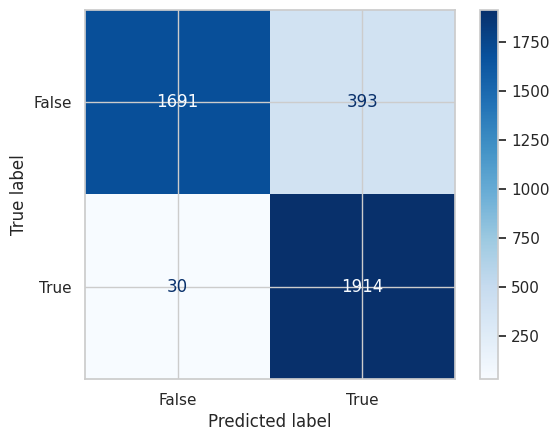

In [62]:
gb_cm = confusion_matrix(y_test, gb_grid_search.best_estimator_.predict(X_test))

# Create a ConfusionMatrixDisplay with the custom colormap
gb_disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm, display_labels=gb_grid_search.classes_)

# Plot the confusion matrix with the custom colormap
gb_disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

## ML Pipeline: Support Vector Classifier

In [68]:
# Define our SVC classifier pipeline
sv_pipe = Pipeline(steps=[('preproc', preproc), ('sv_mdl', SVC(probability=True, random_state=random_seed))])

# Setup our hyperparameters & grid search
sv_tuning_grid = {
  'sv_mdl__C': np.linspace(0.1, 2, 6),      # Regularization parameter (default 1.0)
}


# Perform our grid search
sv_grid_search = GridSearchCV(estimator=sv_pipe, param_grid=sv_tuning_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
sv_grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         ['relative_velocity',
                                                                          'miss_distance',
                                                                          'absolute_magnitude',
                                                                          'est_diameter_avg'])])),
                                       ('sv_mdl',
                                        SVC(probability=True,
                                            random_state=8684))]),
             n_jobs=-1,
             param_grid={'sv_mdl__C': array([0.1 , 0.48, 0.86, 1.24, 1.62, 2.  ])},
             scoring='accuracy', verbose=2)

In [69]:
sv_grid_search.best_params_

{'sv_mdl__C': 2.0}

In [70]:
pd.DataFrame(sv_grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      11.958167      0.441161         1.674983        0.349832   
1      13.185945      1.616847         1.104048        0.040978   
2      12.777352      0.303833         1.095818        0.073672   
3      15.146584      1.674536         1.083984        0.060273   
4      13.079896      1.128286         1.357757        0.467059   
5      12.473244      0.528619         0.836367        0.254836   

  param_sv_mdl__C                             params  split0_test_score  \
0             0.1                 {'sv_mdl__C': 0.1}           0.868885   
1            0.48                {'sv_mdl__C': 0.48}           0.872858   
2            0.86                {'sv_mdl__C': 0.86}           0.873852   
3            1.24  {'sv_mdl__C': 1.2400000000000002}           0.874100   
4            1.62                {'sv_mdl__C': 1.62}           0.874100   
5             2.0                 {'sv_mdl__C': 2.0}           0.874845   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.875341           0.873852         0.872693        0.002760   
1           0.878073           0.879315         0.876749        0.002797   
2           0.880308           0.879811         0.877990        0.002934   
3           0.879811           0.880060         0.877990        0.002753   
4           0.880308           0.881550         0.878652        0.003259   
5           0.880805           0.881550         0.879066        0.003001   

   rank_test_score  
0                6  
1                5  
2                3  
3                3  
4                2  
5                1

In [71]:
sv_train_report = classification_report(y_train, sv_grid_search.best_estimator_.predict(X_train), output_dict=True)
sv_test_report = classification_report(y_test, sv_grid_search.best_estimator_.predict(X_test), output_dict=True)

print("Training performance: ")
print(classification_report(y_train, sv_grid_search.best_estimator_.predict(X_train)))

print("Testing performance: ")
print(classification_report(y_test, sv_grid_search.best_estimator_.predict(X_test)))

Training performance: 
              precision    recall  f1-score   support

       False       0.99      0.78      0.87      6401
        True       0.80      0.99      0.89      5680

    accuracy                           0.88     12081
   macro avg       0.90      0.89      0.88     12081
weighted avg       0.90      0.88      0.88     12081

Testing performance: 
              precision    recall  f1-score   support

       False       0.99      0.79      0.88      2084
        True       0.81      0.99      0.89      1944

    accuracy                           0.89      4028
   macro avg       0.90      0.89      0.89      4028
weighted avg       0.91      0.89      0.89      4028



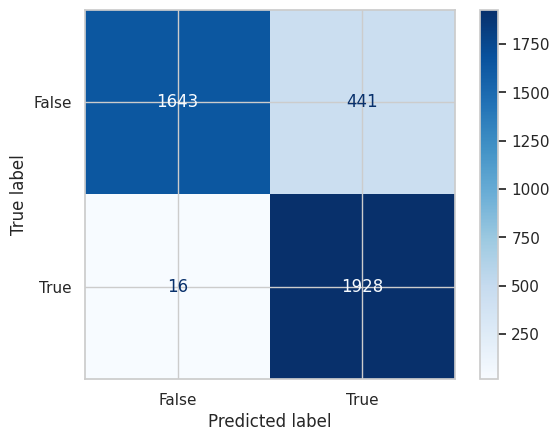

In [72]:
sv_cm = confusion_matrix(y_test, sv_grid_search.best_estimator_.predict(X_test))

# Create a ConfusionMatrixDisplay with the custom colormap
sv_disp = ConfusionMatrixDisplay(confusion_matrix=sv_cm, display_labels=sv_grid_search.classes_)

# Plot the confusion matrix with the custom colormap
sv_disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

## Comparing Model Results

So a total of 4 models were run against the data set, and they roughly performed as follows:



In [73]:
# Model names
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVC']

# Extract metrics from classification_report dictionaries
train_accuracy = [lr_train_report['accuracy'], rf_train_report['accuracy'], gb_train_report['accuracy'], sv_train_report['accuracy']]
test_accuracy = [lr_test_report['accuracy'], rf_test_report['accuracy'], gb_test_report['accuracy'], sv_test_report['accuracy']]

train_precision = [lr_train_report['weighted avg']['precision'], rf_train_report['weighted avg']['precision'], gb_train_report['weighted avg']['precision'], sv_train_report['weighted avg']['precision']]
test_precision = [lr_test_report['weighted avg']['precision'], rf_test_report['weighted avg']['precision'], gb_test_report['weighted avg']['precision'], sv_test_report['weighted avg']['precision']]

train_recall = [lr_train_report['weighted avg']['recall'], rf_train_report['weighted avg']['recall'], gb_train_report['weighted avg']['recall'], sv_train_report['weighted avg']['recall']]
test_recall = [lr_test_report['weighted avg']['recall'], rf_test_report['weighted avg']['recall'], gb_test_report['weighted avg']['recall'], sv_test_report['weighted avg']['recall']]

train_f1 = [lr_train_report['weighted avg']['f1-score'], rf_train_report['weighted avg']['f1-score'], gb_train_report['weighted avg']['f1-score'], sv_train_report['weighted avg']['f1-score']]
test_f1 = [lr_test_report['weighted avg']['f1-score'], rf_test_report['weighted avg']['f1-score'], gb_test_report['weighted avg']['f1-score'], sv_test_report['weighted avg']['f1-score']]

# Create the DataFrame
df = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Train Precision': train_precision,
    'Test Precision': test_precision,
    'Train Recall': train_recall,
    'Test Recall': test_recall,
    'Train F1': train_f1,
    'Test F1': test_f1
})

# create a new column to calculate the difference between train & test
df['Accuracy Gap'] = abs(df['Train Accuracy'] - df['Test Accuracy'])

# sort the data frame
df_sorted = df.sort_values('Accuracy Gap')

# Style the DataFrame
styled_df = df_sorted.style.format({
    'Train Accuracy': "{:.2%}",
    'Test Accuracy': "{:.2%}",
    'Train Precision': "{:.2%}",
    'Test Precision': "{:.2%}",
    'Train Recall': "{:.2%}",
    'Test Recall': "{:.2%}",
    'Train F1': "{:.2%}",
    'Test F1': "{:.2%}"
})

# Display the styled DataFrame
styled_df



We can see that Gradient Boosting performed the most similarly between train and test, followed by Logistic Regression, SVC and Random Forest coming in last.

All of these models perform pretty similarly, averaging in the high 80s for F1 score and accuracy across the board.

Based on these outcomes, I would most likely select gradient boosting as the model to use in production, since it performs very similarly in both train and test environments. The ideal final test would be to sample new data from the JPL API that the models have not seen and see how it performs against those (a holdout set). I would also take another close look at the data prior to fitting to see if I missed anything that needed to be cleaned up.

## Additional Feature Engineering
Rather than add an additional new feature to my data set (as I have already added `est_diameter_avg`), which feels pretty complete at this point, I think I will experiment instead with removing a feature and seeing how that impacts model performance.

My most accurate model has been the gradient boosting classifier, so I will select this as the model to test the impact of feature removal.

I would like to experiment by removing `relative_velocity`, because I don't expect this would have much impact on the model. My reasons for believing this are based on the fact that I know the real calculation of whether or not a NEO is hazardous has nothing to do with how fast it is traveling, so I suspect this data to not be super useful for prediction.

In [78]:
# Create a version of our data frame without `relative_velocity`
no_relative_velocity = balanced_and_pruned.drop(['relative_velocity'], axis=1)

# Split our data again
X_train2, X_test2, y_train2, y_test2 = train_test_split(no_relative_velocity.drop(columns=class_column), no_relative_velocity[class_column], test_size=.25, random_state=random_seed)

# Print out the "shape" of our x data
print(f"X train 2 dimensions: {X_train2.shape}")
print(f"X test 2 dimensions: {X_test2.shape}")
print()
print(f"y train 2 dimensions: {y_train2.shape}")
print(f"y test 2 dimensions: {y_test2.shape}")

# code-level assertions to fail if our counts are not what we expect
assert len(X_train2) == len(y_train2)
assert len(X_test2) == len(y_test2)

X train 2 dimensions: (12081, 3)
X test 2 dimensions: (4028, 3)

y train 2 dimensions: (12081, 1)
y test 2 dimensions: (4028, 1)


In [82]:
# Setup a second pipeline for this run without `relative_velocity` and fit a GBC
num_pipeline2 = Pipeline(steps=[('scale_num', StandardScaler())])

# All of our numeric columns
num_cols2 = ['miss_distance', 'absolute_magnitude', 'est_diameter_avg']

# Setup our preprocessing
preproc2 = ColumnTransformer([('num_pipe', num_pipeline2, num_cols2)],
                             remainder='passthrough')

# Define our gradient boosting classifier pipeline
gb2_pipe = Pipeline(steps=[('preproc', preproc2), ('gb2_mdl', GradientBoostingClassifier(random_state=random_seed))])

# Setup our hyperparameters & grid search
gb2_tuning_grid = {
  'gb2_mdl__n_estimators': [100, 150, 200, 250, 300],          # Number of boosting stages to perform (default=100)
  'gb2_mdl__learning_rate': np.linspace(0.05, 0.3, 6),         # Shrinks contribution of each tree by `learning_rate` (default: 0.1, good results between 0.1 and 0.3 generally, smaller = better)
}


# Perform our grid search
gb2_grid_search = GridSearchCV(estimator=gb2_pipe, param_grid=gb2_tuning_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
gb2_grid_search.fit(X_train2, y_train2.values.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('scale_num',
                                                                                          StandardScaler())]),
                                                                         ['miss_distance',
                                                                          'absolute_magnitude',
                                                                          'est_diameter_avg'])])),
                                       ('gb2_mdl',
                                        GradientBoostingClassifier(random_state=8684))]),
             n_jobs=-1,
             param_grid={'gb2_mdl__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
                         'gb2_mdl__n_estimators': [100, 150, 200, 250, 300]},
             scoring='accuracy', verbose=2)

In [83]:
gb2_grid_search.best_params_

{'gb2_mdl__learning_rate': 0.2, 'gb2_mdl__n_estimators': 250}

In [84]:
pd.DataFrame(gb2_grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.281871      0.063976         0.016033        0.001060   
1        1.859897      0.027490         0.018942        0.000328   
2        2.897164      0.465777         0.029863        0.011181   
3        4.478794      1.039861         0.025515        0.000150   
4        3.904944      0.018798         0.029960        0.001696   
5        1.774953      0.588809         0.029293        0.014656   
6        3.766435      1.055446         0.026508        0.011155   
7        3.234753      0.213557         0.026513        0.007800   
8        6.329808      1.831267         0.045855        0.016404   
9        4.461612      0.859690         0.028765        0.001910   
10       1.293288      0.015619         0.013820        0.000044   
11       4.795396      1.714678         0.034731        0.025292   
12       3.027261      0.309364         0.020166        0.000056   
13       3.708949      0.701716         0.034592        0.015790   
14       4.987659      1.022628         0.033176        0.008548   
15       1.295276      0.029714         0.014236        0.000793   
16       1.969082      0.105562         0.016863        0.000356   
17       4.911379      0.582046         0.040638        0.001511   
18       4.162989      0.823397         0.024076        0.000668   
19       3.902502      0.072485         0.026927        0.000237   
20       1.951468      0.550072         0.027473        0.010098   
21       2.849568      0.691116         0.017112        0.000344   
22       2.575719      0.031503         0.023566        0.004498   
23       3.672540      0.649895         0.033399        0.012205   
24       5.024122      1.025676         0.027002        0.000297   
25       1.290142      0.009452         0.013237        0.000082   
26       1.937168      0.011072         0.017000        0.000512   
27       4.019247      0.894464         0.033947        0.009563   
28       4.035852      0.563627         0.025179        0.002294   
29       4.339990      0.293661         0.035351        0.011485   

   param_gb2_mdl__learning_rate param_gb2_mdl__n_estimators  \
0                          0.05                         100   
1                          0.05                         150   
2                          0.05                         200   
3                          0.05                         250   
4                          0.05                         300   
5                           0.1                         100   
6                           0.1                         150   
7                           0.1                         200   
8                           0.1                         250   
9                           0.1                         300   
10                         0.15                         100   
11                         0.15                         150   
12                         0.15                         200   
13                         0.15                         250   
14                         0.15                         300   
15                          0.2                         100   
16                          0.2                         150   
17                          0.2                         200   
18                          0.2                         250   
19                          0.2                         300   
20                         0.25                         100   
21                         0.25                         150   
22                         0.25                         200   
23                         0.25                         250   
24                         0.25                         300   
25                          0.3                         100   
26                          0.3                         150   
27                          0.3                         200   
28                          0.3                         250   
29   

In [85]:
gb2_train_report = classification_report(y_train2, gb2_grid_search.best_estimator_.predict(X_train2), output_dict=True)
gb2_test_report = classification_report(y_test2, gb2_grid_search.best_estimator_.predict(X_test2), output_dict=True)

print("Training performance: ")
print(classification_report(y_train2, gb2_grid_search.best_estimator_.predict(X_train2)))

print("Testing performance: ")
print(classification_report(y_test2, gb2_grid_search.best_estimator_.predict(X_test2)))

Training performance: 
              precision    recall  f1-score   support

       False       0.99      0.83      0.90      6401
        True       0.84      0.99      0.91      5680

    accuracy                           0.90     12081
   macro avg       0.91      0.91      0.90     12081
weighted avg       0.92      0.90      0.90     12081

Testing performance: 
              precision    recall  f1-score   support

       False       0.98      0.81      0.88      2084
        True       0.83      0.98      0.90      1944

    accuracy                           0.89      4028
   macro avg       0.90      0.89      0.89      4028
weighted avg       0.91      0.89      0.89      4028



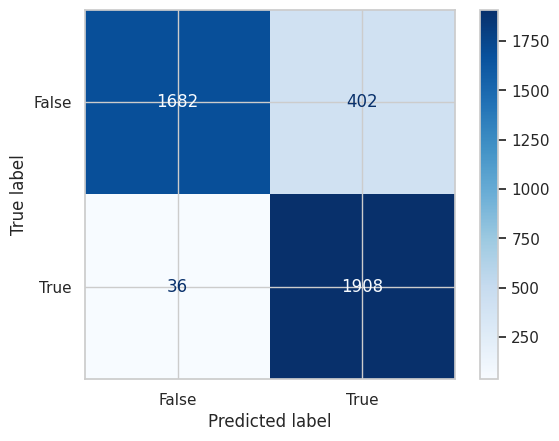

In [86]:
gb2_cm = confusion_matrix(y_test2, gb2_grid_search.best_estimator_.predict(X_test2))

# Create a ConfusionMatrixDisplay with the custom colormap
gb2_disp = ConfusionMatrixDisplay(confusion_matrix=gb2_cm, display_labels=gb2_grid_search.classes_)

# Plot the confusion matrix with the custom colormap
gb2_disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.show()

In [88]:
feat_comparison_models = ['GBC w/ relative_velocity', 'GBC w/o relative_velocity']

# Extract metrics from classification_report dictionaries
comp_train_accuracy = [gb_train_report['accuracy'], gb2_train_report['accuracy']]
comp_test_accuracy = [gb_test_report['accuracy'], gb2_test_report['accuracy']]

comp_train_precision = [gb_train_report['weighted avg']['precision'], gb2_train_report['weighted avg']['precision']]
comp_test_precision = [gb_test_report['weighted avg']['precision'], gb2_test_report['weighted avg']['precision']]

comp_train_recall = [gb_train_report['weighted avg']['recall'], gb2_train_report['weighted avg']['recall']]
comp_test_recall = [gb_test_report['weighted avg']['recall'], gb2_test_report['weighted avg']['recall']]

comp_train_f1 = [gb_train_report['weighted avg']['f1-score'], gb2_train_report['weighted avg']['f1-score']]
comp_test_f1 = [gb_test_report['weighted avg']['f1-score'], gb2_test_report['weighted avg']['f1-score']]

# Create the DataFrame
comp_df = pd.DataFrame({
    'Model': feat_comparison_models,
    'Train Accuracy': comp_train_accuracy,
    'Test Accuracy': comp_test_accuracy,
    'Train Precision': comp_train_precision,
    'Test Precision': comp_test_precision,
    'Train Recall': comp_train_recall,
    'Test Recall': comp_test_recall,
    'Train F1': comp_train_f1,
    'Test F1': comp_test_f1
})

# create a new column to calculate the difference between train & test
comp_df['Accuracy Gap'] = abs(comp_df['Train Accuracy'] - comp_df['Test Accuracy'])

# sort the data frame
comp_df_sorted = comp_df.sort_values('Accuracy Gap')

# Style the DataFrame
comp_styled_df = comp_df_sorted.style.format({
    'Train Accuracy': "{:.2%}",
    'Test Accuracy': "{:.2%}",
    'Train Precision': "{:.2%}",
    'Test Precision': "{:.2%}",
    'Train Recall': "{:.2%}",
    'Test Recall': "{:.2%}",
    'Train F1': "{:.2%}",
    'Test F1': "{:.2%}"
})

# Display the styled DataFrame
comp_styled_df

## Conclusions from Additional Feature Engineering

Examining the detailed comparison above, I can see that while the GBC w/o relative velocity performed better in training, the GBC w/ relative velocity did a better job on testing, and performed much more in line with the training set.

Based on this, I have to conclude that the model appears to be using this feature in its determination, as the removal has (albeit slightly) negatively impacted the performance!

I did not expect this, and am pleasantly surprised to see this result. For future work, it would be fun to try removing other features to see how gravely they impact model performance.